## Pacchetti da installare

In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.2 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 21.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import notebook

In [4]:
import os
import re
import datetime
import pathlib
import json
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

import matplotlib.pyplot as plt

from typing import Tuple


In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Variabili Globali

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'train_data.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_multi_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_multi_bert_dante'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
multilingual_vocab_finalname = 'multilingual_vocab.txt'
ita_vocab_finalname = 'ita_dante_vocab.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
multilingual_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, multilingual_vocab_finalname))
ita_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, ita_vocab_finalname))

# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'
TYPE_COLUMN ='Type'

## Iper Parametri Modello

In [7]:
NUM_SAMPLES = 25000
TEST = 200
TEST_SIZE = 0.3

MAX_VOCAB_SIZE = 30000 
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 128

NUM_LAYERS = 1 # Numero di layer di Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 20

# IMPOSTO IL DEBUG A TRUE 
debug = True
trainable = False
training = True

## Parametri BERT

In [8]:
bert_model_name = 'distilbert_multi_cased_L-6_H-768_A-12/1'  
tfhub_handle_preprocess = 'https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2'
tfhub_handle_encoder =  'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1'

if debug:
  print('BERT model name                    : ', bert_model_name)
  print('BERT model selected                : ', tfhub_handle_encoder)
  print('BERT preprocess                    : ', tfhub_handle_preprocess)

BERT model name                    :  distilbert_multi_cased_L-6_H-768_A-12/1
BERT model selected                :  https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1
BERT preprocess                    :  https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2


## DATASET

### Caricamento Dati

In [9]:
def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",", "'", "’")
  '''
  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri apostrofo
  w = re.sub(r"([’]+)", "'", w)

  w = w.replace("á", "à")
  w = w.replace("é", "è")
  w = w.replace("í", "ì")
  w = w.replace("ó", "ò")
  w = w.replace("ú", "ù")
  w = w.replace('"', " ")
  w = w.replace(':', " ")
  w = w.replace('«', " ")
  w = w.replace('»', " ")
  w = w.replace('‘', " ")
  w = w.replace('-', " ")
  w = w.replace('[', " ")
  w = w.replace(']', " ")
  w = w.replace('(', " ")
  w = w.replace(')', " ")
  w = w.replace("•", " ")
  w = w.replace("..", ".")
  w = w.replace("...", ".")
  w = w.replace("\xa0", " ")
  w = w.replace("\xc3\xa8", " ")
  w = w.replace("\xe2\x80\xaf", " ")
  w = w.replace("   ", " ")
  w = w.replace("–", " ")
  w = w.replace("“", " ")
  w = w.replace("”", " ")
  w = w.replace("„", " ")
  w = w.replace("─", " ")
  w = w.replace("♪", " ")
  w = w.replace("#", " ")
  w = w.replace("/", " ")
  w = w.replace("=", " ")
  w = w.replace(">", " ")
  w = w.replace("\\", " ")
  w = w.replace("`", " ")
  w = w.replace("¡", " ")
  w = w.replace("¿", " ")
  w = w.replace("œ", " ")
  w = w.replace("♗", " ")
  w = w.replace("♘", " ")
  w = w.replace("《", " ")
  w = w.replace("》", " ")
  # w = w.replace("", " ")
  # w = w.replace("", " ")

  # inserimento di uno spazio dopo apostrofo
  w = re.sub(r"(['])", r"\1 ", w) 

  w = w.replace(" ' ", " '")

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

In [10]:
df = pd.read_csv(
  train_data_filenamepath,
  usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN, TYPE_COLUMN],
)

# Preprocessing dei dati di Input
df[ORIGINAL_COLUMN] = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence(x))

# Preprocessing dei dati Target con aggiunta del token di fine frase
df[TRANSLATE_COLUMN] = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x))

if debug:
  print(f'Dati totali presenti nel Dataset               : {len(df)}')
  print('----------------------------------- TRAIN SET -----------------------------------------')
  print((df[ORIGINAL_COLUMN].tolist())[-1:])
  print((df[TRANSLATE_COLUMN].tolist())[-1:])
  print((df[ORIGINAL_COLUMN].tolist())[:1])
  print((df[TRANSLATE_COLUMN].tolist())[:1])

Dati totali presenti nel Dataset               : 379582
----------------------------------- TRAIN SET -----------------------------------------
['Min önskan och vilja styrdes av gudomlig kärlek som driver solen och andra stjärnor framåt som ett hjul flyttade regelbundet . ']
[" ma già volgeva il mio disio e 'l velle , sì come rota ch' igualmente è mossa , l' amor che move il sole e l' altre stelle"]
["De même que , en temps de guerre , officiers et soldats se sentent autorisès par l' opinion gènèrale à commettre des actes qui , en temps de paix , sont tenus pour criminels , de même les rèvolutionnaires , dans leur lutte , se regardaient comme couverts par l' opinion de leur cercle , en vertu de laquelle les actes de cruautè qu' ils commettaient ètaient nobles et moraux , ètant commis par eux au prix de leur libertè , de leur vie , de tout ce qui est cher à la plupart des hommes . Ainsi s' expliquait , que des personnes excellentes , incapables non seulement de causer une souffrance , m

## Tokenizer

Creo due differenti tokenizer che mi servizranno per la predisposizione dei dati di input:


*   EncTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Encoder di Bert
*   DecTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Decoder



In [11]:
input_data_vocab = df[ORIGINAL_COLUMN].tolist()
target_data_vocab = df[TRANSLATE_COLUMN].tolist()

dataset = tf.data.Dataset.from_tensor_slices((input_data_vocab, target_data_vocab))
dataset = dataset.shuffle(len(input_data_vocab)).batch(BATCH_SIZE, drop_remainder=True)

train_multilingual = dataset.map(lambda multilingual, ita: multilingual)
train_ita = dataset.map(lambda multilingual, ita: ita)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [12]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [13]:
def cleanup_text(reserved_tokens, token_txt):

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [14]:
tokenizers = tf.Module()

### Classe EncTokenizer

Classe custom per la tokenizzazione dei dati di italiano e che crea i tre vettori necessari al layer di Encoder 
Bert:


*   input_word_ids
*   input_type_ids
*   input_mask





In [15]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens = {
  'start_of_sequence_id': 101,
  'end_of_segment_id': 102,
  'padding_id': 0,
  'mask_id': 103
}

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [16]:
exist_vocab = Path(multilingual_vocab_filenamepath)

if not exist_vocab.exists():
  multilingual_vocab = bert_vocab.bert_vocab_from_dataset(
      train_multilingual.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(multilingual_vocab_filenamepath, multilingual_vocab)

In [17]:
class EncTokenizer(tf.Module):
  def __init__(self, tfhub_handle_preprocess):
    self.preprocessor = hub.KerasLayer(tfhub_handle_preprocess)
    
  @tf.function
  def tokenize(self, strings):
    return self.preprocessor(strings)

In [18]:
tokenizers.multilingual = EncTokenizer(tfhub_handle_preprocess)

### Classe DecTokenizer

Classe custom per la tokenizzazione dei dati in lingua italiana per il layer di Decoder


In [19]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens_vocab=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens_vocab,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [20]:
exist_vocab = Path(ita_vocab_filenamepath)

if not exist_vocab.exists():
  ita_vocab = bert_vocab.bert_vocab_from_dataset(
      train_ita.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(ita_vocab_filenamepath, ita_vocab)

In [21]:
START = tf.argmax(tf.constant(reserved_tokens_vocab) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens_vocab) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape(out_type=tf.int32)[0]

  starts = tf.fill([count,1], START)
  starts = tf.cast(starts, tf.int32)

  ends = tf.fill([count,1], END)
  ends = tf.cast(ends, tf.int32)

  x = tf.concat([starts, ragged, ends], axis=1)
  return x

In [22]:
class DecTokenizer(tf.Module):
  def __init__(self, reserved_tokens_vocab, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens_vocab
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens_vocab)

In [23]:
tokenizers.ita = DecTokenizer(reserved_tokens_vocab, ita_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [24]:
print(f'Vocabolario Italiano : {tokenizers.ita.get_vocab_size()}')

Vocabolario Italiano : 23120


## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [25]:
def split_dataset(df: pd.DataFrame,
                  filter_column: str, 
                  debug: bool = False) -> Tuple:

  print(f'Lunghezza df {len(df)}')
  dataset = (df.loc[df[TYPE_COLUMN] == filter_column]).copy() 
  print(f'Lunghezza dataset {len(dataset)}')
  
  if NUM_SAMPLES > 0:
    dataset = dataset[:NUM_SAMPLES]

  input_data = dataset[ORIGINAL_COLUMN].tolist()
  target_data = dataset[TRANSLATE_COLUMN].tolist()

  train_input_data, validation_input_data, train_target_data, validation_target_data = train_test_split(
    input_data[:-TEST], 
    target_data[:-TEST], 
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=True
  ) 

  train_input_data = train_input_data[:(int((len(train_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
  train_target_data = train_target_data[:(int((len(train_target_data) / BATCH_SIZE)) * BATCH_SIZE)]
  
  validation_input_data = validation_input_data[:(int((len(validation_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
  validation_target_data = validation_target_data[:(int((len(validation_target_data) / BATCH_SIZE)) * BATCH_SIZE)]

  test_input_data = input_data[len(train_input_data)+len(validation_input_data):]
  test_target_data = target_data[len(train_target_data)+len(validation_target_data):]

  if debug:
    print(f'Dati totali presenti nel Dataset               : {len(df)}')
    print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
    print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
    print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')


    print('----------------------------------- TRAIN SET -----------------------------------------')
    print(train_input_data[-4:])
    print(train_target_data[-4:])
    print('--------------------------------- VALIDATION SET --------------------------------------')
    print(validation_input_data[-4:])
    print(validation_target_data[-4:])
    print('----------------------------------- TEST SET ------------------------------------------')
    print(test_input_data[-4:])
    print(test_target_data[-4:])

    print('-------------------------------- ANALISI DATI -----------------------------------------')
    print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
    print(f'Frase più corta nel Dataset Input di Train             : {min(train_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Train            : {min(train_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Train             : {max(train_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Train            : {max(train_target_data, key = len)}')
    print('---------------------------------------------------------------------------------------')
    print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
    print(f'Frase più corta nel Dataset Input di Validation        : {min(validation_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Validation       : {min(validation_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Validation        : {max(validation_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Validation       : {max(validation_target_data, key = len)}')
    print('---------------------------------------------------------------------------------------')
    print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
    print(f'Frase più corta nel Dataset Input di Test              : {min(test_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Test             : {min(test_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Test              : {max(test_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Test             : {max(test_target_data, key = len)}')    

    print('\n--------------------------------- EXAMPLE ---------------------------------------------')
    print([min(train_input_data, key = len)])
    print(tokenizers.multilingual.tokenize([min(train_input_data, key = len)])['input_word_ids'][:, :32])
    print('------------------------------------------------------------------')
    print([min(train_target_data, key = len)])
    print(tokenizers.ita.tokenize([min(train_target_data, key = len)]))
    print('\n')
    print([max(train_input_data, key = len)])
    print(tokenizers.multilingual.tokenize([max(train_input_data, key = len)])['input_word_ids'])
    print('------------------------------------------------------------------')
    print([max(train_target_data, key = len)])
    print(tokenizers.ita.tokenize([max(train_target_data, key = len)]))  
  
  return train_input_data, validation_input_data, test_input_data, train_target_data, validation_target_data, test_target_data 

In [26]:
def prepare_batch(multilingual, ita):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int32)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.multilingual.tokenize(multilingual)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  ita = tokenizers.ita.tokenize(ita)
  decoder = ita[:, :-1].to_tensor()  # Drop the [END] tokens
  target = ita[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [27]:
def make_batches(ds):
  return (
    ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare_batch, tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [28]:
def train_val_test_dataset(df: pd.DataFrame, 
                          filter_column: str, 
                          debug: bool = False) -> Tuple:

  # Recupero il dataset 
  train_input_data, validation_input_data, test_input_data, train_target_data, validation_target_data, test_target_data = split_dataset(df=df, filter_column=filter_column, debug=debug)

  # Definizione del dataset
  # [from_tensor_slices] permette di recuperare batch
  # di esempi dai dataset di riferimento
  train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))
  test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

  # impostazione del recupero di esempi presi in maniera
  # casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
  train_dataset = make_batches(train_dataset)
  validation_dataset = make_batches(validation_dataset)

  return train_dataset, validation_dataset, test_dataset

In [29]:
train_dataset_ita, validation_dataset_ita, test_dataset = train_val_test_dataset(df=df,
                                                                                 filter_column='ITA',
                                                                                 debug=debug)

Lunghezza df 379582
Lunghezza dataset 244398
Dati totali presenti nel Dataset               : 379582
Dati totali presenti nel Dataset di Train      : 17344
Dati totali presenti nel Dataset di Validation : 7424
Dati totali presenti nel Dataset di Test       : 232

----------------------------------- TRAIN SET -----------------------------------------
["C' est le braquage de banque le plus sanglant qu' a connu ce pays . ", "Il s' est converti au christianisme . ", 'Vous pouvez ècrire dans la langue que vous voulez . Sur Tatoeba , toutes les langues sont ègales . ', 'Elle a trois s urs une est infirmière et les autres sont enseignantes . ']
['È la rapina in banca più sanguinosa della storia di questo paese . ', 'Si è convertito al Cristianesimo . ', 'Puoi scrivere in qualsiasi lingua desideri . Su Tatoeba tutte le lingue sono uguali . ', 'Lei ha tre sorelle una è infermiera e le altre sono insegnanti . ']
--------------------------------- VALIDATION SET -----------------------------------

In [30]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset_ita.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 128)
Word Ids                 : [  101 52208 10830 34394 34595 10171 49641 10154   187   112 38425 14598
   119   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [71]:
embedding_dim = 32

class MLPMixerLayer(tf.keras.layers.Layer):
  def __init__(self, num_patches, dropout_rate, *args, **kwargs):
    super().__init__(*args, **kwargs)
    print(f'num_patches {num_patches}')
    self.mlp = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units=num_patches, activation='relu'),
            tf.keras.layers.Dense(units=num_patches),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ]
    )
    self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs):
    # Apply layer normalization.
    x = self.normalize(inputs)
    # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
    x_channels = tf.linalg.matrix_transpose(x)
    # Apply mlp on each channel independently.
    mlp_outputs = self.mlp(x_channels)
    # Transpose mlp_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
    mlp_outputs = tf.linalg.matrix_transpose(mlp_outputs)
    return mlp_outputs

In [75]:
class EncoderBert(tf.keras.layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len, rate=0.5, trainable=False):
    super(EncoderBert, self).__init__()

    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder', trainable=trainable)

    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim * 2, 1, activation='relu') 
    self.conv_3 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    # self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.mlp_mixer = MLPMixerLayer(num_patches=embedding_dim // 4, dropout_rate=rate)
    self.max_len = max_len

  def call(self, x, debug=False):

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :16]}')
      print(f'Input Mask                   : {x["input_mask"][0, :16]}')
      
    x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    # x = self.encoder(x)['encoder_outputs'] 
    # x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :16]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.conv_3(x)
    if debug:
     print(f'Sequence Conv3 Shape          : {x.shape}')
      
    x = self.mlp_mixer(x)
    if debug:
      print(f'Sequence MLP-Mixer Shape     : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :16]}')      
      print('*********************************************************') 

    # x = self.lambda_layer(x)
    # if debug:
    #   print(f'Sequence Lambda Layer        : {x.shape}')
    #   print()
    #   print(f'Sequence Outputs Values      : {x[0, 0, :16]}')      
    #   print('*********************************************************') 

    return x

In [76]:
'''
128, 768 Bert
128, 128 conv1d
128, 128 Trasposto
128, 32 Dense
32, 128 Trasposto Uscita Bert Encoder
'''

'\n128, 768 Bert\n128, 128 conv1d\n128, 128 Trasposto\n128, 32 Dense\n32, 128 Trasposto Uscita Bert Encoder\n'

In [77]:
encoder_bert = EncoderBert(bert_encoder=tfhub_handle_encoder, 
                           embedding_dim=EMBEDDING_DIM, 
                           max_len=MAX_SEQ_LENGTH,
                           rate=DROPUOT,
                           trainable=trainable)

bert_outputs = encoder_bert(enc_input, debug) 

num_patches 32
****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask']
Shape                        : (32, 128)
Word Ids                     : [  101 52208 10830 34394 34595 10171 49641 10154   187   112 38425 14598
   119   102     0     0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.05340564 -0.00303204 -0.1578381   0.23718458 -0.10183904  0.11595948
  -0.10829279  0.00831296 -0.06592342  0.51070666  0.35922247 -0.24354595
  -0.07508986  0.12717839 -0.52456385  0.04772909]]

Sequence Conv1 Shape         : (32, 128, 512)
Sequence Conv2 Shape         : (32, 128, 256)
Sequence Conv3 Shape          : (32, 128, 128)
Sequence MLP-Mixer Shape     : (32, 32, 128)

Sequence Outputs Values      : [ 0.8292772   0.15414067  0.34332967  0.28950003  1.7654581   0.201365
  0.567627    0.21004419  0.60983044  0.21004419

In [46]:
num_patches = 32

bert_outputs = mlp_mixer(bert_outputs) 

inputs shape (32, 128, 256)
x shape (32, 128, 256)
x_channels shape (32, 256, 128)
mlp1_outputs shape (32, 256, 32)
mlp1_outputs shape (32, 32, 256)


## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [33]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [34]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.ita.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 128
Sequence Shape                            : [ 32 128]
Shape TokenAndPositionEmbedding           : (32, 128, 128)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [35]:
class DecodeBert(tf.keras.layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential(
      [tf.keras.layers.Dense(ff_dim, activation='relu'), 
       tf.keras.layers.Dense(embed_dim),]
    )
    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [36]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 128, 128)
Shape Output Layer Decode-Bert      : (32, 128, 128)
*********************************************************


#### Layer Decoder

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential(
      [tf.keras.layers.Dense(ff_dim, activation='relu'), 
       tf.keras.layers.Dense(embed_dim),]
    )
    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.layernorm3 = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [38]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 128, 128)
Shape Output Layer Decode-Bert      : (32, 128, 128)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 128, 128)
Shape Outputs Decoder             : (32, 128, 128)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [39]:
class TransformerBlock(tf.keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               trainable,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len, trainable=trainable)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [40]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.ita.get_vocab_size(),
                               tfhub_handle_encoder,
                               trainable,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_word_ids']
Shape                        : (32, 128)
Word Ids                     : [  101 10159 24239   187   112 45754   100 10110 21096   119   102     0
     0     0     0     0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.03327592  0.05808669  0.13086411  0.1270645  -0.05396995 -0.02335626
  -0.18837294  0.14862062  0.00092175  0.48506987  0.2808432  -0.19578753
  -0.4992058   0.13423905 -0.6468562   0.02476236]]

Sequence Conv1 Shape         : (32, 128, 512)
Sequence Conv2 Shape         : (32, 128, 128)
Sequence Lambda Layer        : (32, 128, 128)

Sequence Outputs Values      : [0.9901202  0.04264219 0.18161763 0.31579095 0.31039956 0.83884466
 0.01011574 0.         0.18807004 0.19593099 0.2832985  0.
 0.11893892 0.         0.         0.        ]
********

In [41]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 2975744   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 135193472 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  1592224   
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  2982480   
                                                 

## Addestramento Modello

### Compilazione

In [42]:
transformer.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                     beta_1=BETA_1, 
                                     beta_2=BETA_2),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Callbacks

In [43]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
  on_epoch_end=lambda epoch, logs: json_log.write(
    json.dumps({'epoch': epoch, 
                'loss': logs['loss'],
                'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                'val_loss': logs['val_loss'],
                'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
  on_train_end=lambda logs: json_log.close()
)

### Train Ita

In [ ]:
start = datetime.datetime.now()
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_ita,
                initial_epoch=0,
                epochs=EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_ita,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/20
542/542 [==============================] - 458s 834ms/step - loss: 3.6724 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.9160
Epoch 2/20
542/542 [==============================] - 424s 783ms/step - loss: 0.6110 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.5135 - val_sparse_categorical_accuracy: 0.9321
Epoch 3/20
542/542 [==============================] - 454s 838ms/step - loss: 0.5083 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.9353
Epoch 4/20
542/542 [==============================] - 454s 838ms/step - loss: 0.4673 - sparse_categorical_accuracy: 0.9352 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.9377
Epoch 5/20
542/542 [==============================] - 454s 837ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.4137 - val_sparse_categorical_accuracy: 0.9403
Epoch 6/20
542/542 [==============================] - 452s 834ms/step - loss: 0.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_ita,
                initial_epoch=EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_ita,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 21/40
542/542 [==============================] - 433s 789ms/step - loss: 0.2309 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.2706 - val_sparse_categorical_accuracy: 0.9595
Epoch 22/40
542/542 [==============================] - 461s 851ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.2663 - val_sparse_categorical_accuracy: 0.9599
Epoch 23/40
542/542 [==============================] - 463s 854ms/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.2649 - val_sparse_categorical_accuracy: 0.9606
Epoch 24/40
542/542 [==============================] - 430s 793ms/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.9613
Epoch 25/40
542/542 [==============================] - 429s 792ms/step - loss: 0.2058 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.2594 - val_sparse_categorical_accuracy: 0.9618
Epoch 26/40
542/542 [==============================] - 460s 849ms/step - lo

### Train Dante

In [48]:
train_dataset_dante, validation_dataset_dante, test_dataset = train_val_test_dataset(df=df, filter_column='DANTE', debug=debug)

Lunghezza df 379582
Lunghezza dataset 135184
Dati totali presenti nel Dataset               : 379582
Dati totali presenti nel Dataset di Train      : 17344
Dati totali presenti nel Dataset di Validation : 7424
Dati totali presenti nel Dataset di Test       : 232

----------------------------------- TRAIN SET -----------------------------------------
['E al pelare conviene avere maniera , ', 'essayer , comprendre et ècouter', 'e così si pentirà della sua follia . ', 'mostrando di fare vita agreste , ']
['E al pelar convien aver maniera , ', 'A ritenere intendi , e a udire , ', 'Sì ssi ripentirà di sua follia . ', "Mostrando ched i' faccia vita agresta;"]
--------------------------------- VALIDATION SET --------------------------------------
['Si je le dis pour le tromper . ', "con tutt' altro che nobile e vero amore . ", 'ihren Status und ihren Zustand;', "Et il n' a jamais dit un vrai mot . "]
["Ched i' non dica ciò per inghanarlo . ", 'Se non di fino e di leal amore . ', 'Di loro stat

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=EPOCHS_ADAM+EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 41/60
542/542 [==============================] - 470s 854ms/step - loss: 0.4691 - sparse_categorical_accuracy: 0.9411 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.9483
Epoch 42/60
542/542 [==============================] - 428s 789ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.3192 - val_sparse_categorical_accuracy: 0.9515
Epoch 43/60
542/542 [==============================] - 457s 843ms/step - loss: 0.3390 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.2929 - val_sparse_categorical_accuracy: 0.9536
Epoch 44/60
542/542 [==============================] - 427s 788ms/step - loss: 0.3114 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.2727 - val_sparse_categorical_accuracy: 0.9555
Epoch 45/60
542/542 [==============================] - 454s 838ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2554 - val_sparse_categorical_accuracy: 0.9571
Epoch 46/60
542/542 [==============================] - 428s 789ms/step - lo

In [ ]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 61/80
542/542 [==============================] - 459s 838ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.1401 - val_sparse_categorical_accuracy: 0.9709
Epoch 62/80
542/542 [==============================] - 454s 838ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.1367 - val_sparse_categorical_accuracy: 0.9715
Epoch 63/80
542/542 [==============================] - 456s 842ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1337 - val_sparse_categorical_accuracy: 0.9720
Epoch 64/80
542/542 [==============================] - 423s 781ms/step - loss: 0.1343 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1300 - val_sparse_categorical_accuracy: 0.9725
Epoch 65/80
542/542 [==============================] - 453s 836ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.1291 - val_sparse_categorical_accuracy: 0.9728
Epoch 66/80
542/542 [==============================] - 424s 783ms/step - lo

In [ ]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 81/100
542/542 [==============================] - 455s 821ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.1066 - val_sparse_categorical_accuracy: 0.9780
Epoch 82/100
542/542 [==============================] - 441s 814ms/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.1068 - val_sparse_categorical_accuracy: 0.9780
Epoch 83/100
542/542 [==============================] - 442s 815ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.1052 - val_sparse_categorical_accuracy: 0.9784
Epoch 84/100
542/542 [==============================] - 438s 808ms/step - loss: 0.0863 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.1053 - val_sparse_categorical_accuracy: 0.9787
Epoch 85/100
542/542 [==============================] - 443s 818ms/step - loss: 0.0849 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.1050 - val_sparse_categorical_accuracy: 0.9786
Epoch 86/100
542/542 [==============================] - 408s 754ms/ste

In [ ]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 101/120
542/542 [==============================] - 463s 839ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.1000 - val_sparse_categorical_accuracy: 0.9807
Epoch 102/120
542/542 [==============================] - 473s 873ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0999 - val_sparse_categorical_accuracy: 0.9811
Epoch 103/120
542/542 [==============================] - 447s 825ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0998 - val_sparse_categorical_accuracy: 0.9810
Epoch 104/120
542/542 [==============================] - 440s 812ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0993 - val_sparse_categorical_accuracy: 0.9812
Epoch 105/120
542/542 [==============================] - 447s 825ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0983 - val_sparse_categorical_accuracy: 0.9814
Epoch 106/120
542/542 [==============================] - 469s 866

## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

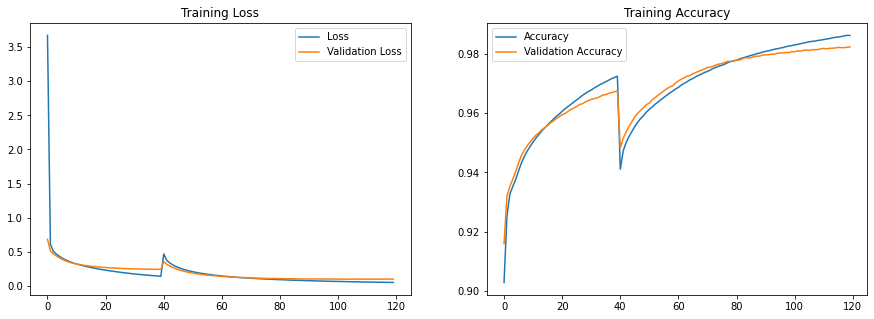

In [ ]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [49]:
trainable = False

transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.ita.get_vocab_size(),
                               tfhub_handle_encoder,
                               trainable,
                               DROPUOT)

In [50]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [51]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = (df[ORIGINAL_COLUMN].tolist())[np.random.choice(len(df[ORIGINAL_COLUMN].tolist()))]
      print(input_text)

    inputs_bert = self.tokenizers.multilingual.tokenize(input_text)

    start_end = self.tokenizers.ita.tokenize([''])[0]
    start = (start_end[0][tf.newaxis]).numpy()[0]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int32, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([start]))     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer((inputs_bert, output), 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (tf.keras.backend.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.ita.detokenize(output)[0]  
    tokens = tokenizers.ita.lookup(output)[0]

    return text, tokens

In [53]:
translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for test_input_data, test_target_data in test_dataset.take(50):
  test_input_data = test_input_data.numpy().decode()
  test_target_data = test_target_data.numpy().decode()

  text, token = translate.predict(tf.constant([test_input_data]), MAX_SEQ_LENGTH)

  print(f'{"Input":15s}: {test_input_data}')
  print(f'{"Target":15s}: {test_target_data}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

Input          : Je lui ai fait croire que son bien être
Target         : A chui intender faciea , che 'l su' disdotto
Prediction     : a chui intender faciea , che ' l su ' disdotto
---------------------------------------------
Input          : J' ètais plus excitèe que tout . 
Target         : Mi piaciea più che null' altro , ch' e' ssia . 
Prediction     : e piu arditamente contr ' a llui piu che fele ;
---------------------------------------------
Input          : J' ètais sèduisante , jeune et drôle . 
Target         : I' era bella , e giovane , e folletta , 
Prediction     : e ' fu fondato per folle e fornita
---------------------------------------------
Input          : Mais il n' ètait pas à l' ècole d' affection . 
Target         : Ma non era a la scuola de l' Amore
Prediction     : ma non era a l ' amor unquanche conosciuto ,
---------------------------------------------
Input          : C' ètait; cependant , je le sais maintenant en profondeur par c ur . 
Target         : Is

In [58]:
  text_input_data = 'Ieri sono andato al supermercato'

  text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
  print(f'{"Input":15s}: {text_input_data}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

Input          : Ieri sono andato al supermercato
Prediction     : i ' van cherendo lor vita ,
---------------------------------------------


In [59]:
  text_input_data = 'ho comprato la cocacolo'

  text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
  print(f'{"Input":15s}: {text_input_data}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

Input          : ho comprato la cocacolo
Prediction     : i ' potre ' ben tosto confortato ,
---------------------------------------------
